# Liesel-GAM Demo Notebook

## Setup and Imports

In [16]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [17]:
def gen_tp_data(n=400, noise_sd=0.3, grid=False, seed=1):
    """
    Generate test data for tensor-product smooths.

    Parameters
    ----------
    n : int
        Number of samples (if grid=False).
    noise_sd : float
        Standard deviation of Gaussian noise.
    grid : bool
        If True, generate approximately n points on a regular grid.
        If False, generate random design points.
    seed : int
        Random seed.

    Returns
    -------
    pandas.DataFrame with columns: x, y, eta (signal), z (noisy response)
    """
    rng = np.random.default_rng(seed)

    # --- Design ----
    if grid:
        m = int(np.ceil(np.sqrt(n)))
        xs = np.linspace(0, 1, m)
        ys = np.linspace(0, 1, m)
        x, y = np.meshgrid(xs, ys, indexing="xy")
        x = x.ravel()
        y = y.ravel()
    else:
        x = rng.uniform(0, 1, n)
        y = rng.uniform(0, 1, n)

    # --- True non-separable smooth ----
    def f_true(x, y):
        return (
            1.5 * np.sin(2 * np.pi * x) * np.cos(3 * np.pi * y)
            + 0.8 * x * y
            + 2.0 * np.exp(-(((x - 0.65) ** 2) / 0.01 + ((y - 0.35) ** 2) / 0.06))
        )

    eta = f_true(x, y)
    z = eta + rng.normal(scale=noise_sd, size=len(eta))

    return pd.DataFrame({"x": x, "y": y, "eta": eta, "z": z})

In [18]:
df = gen_tp_data(n=600, noise_sd=0.25, grid=False, seed=42)
print(df.head())

          x         y       eta         z
0  0.773956  0.477506  0.935849  0.689560
1  0.438878  0.761433  0.621075  0.405865
2  0.858598  0.903328  1.334100  1.948456
3  0.697368  0.720696 -0.674870 -0.224435
4  0.094177  0.963211 -0.714339 -0.817277


In [19]:
df_grid = gen_tp_data(n=5000, grid=True)

In [20]:
df_grid

,x,y,eta,z
0,0.000000,0.0,1.162528e-19,0.103675
1,0.014286,0.0,1.344590e-01,0.380944
2,0.028571,0.0,2.678353e-01,0.366966
3,0.042857,0.0,3.990553e-01,0.008108
4,0.057143,0.0,5.270622e-01,0.798669
...,...,...,...,...
5036,0.942857,1.0,1.281348e+00,1.076909
5037,0.957143,1.0,1.164770e+00,1.171729
5038,0.971429,1.0,1.044978e+00,1.027468
5039,0.985714,1.0,9.230304e-01,0.818835


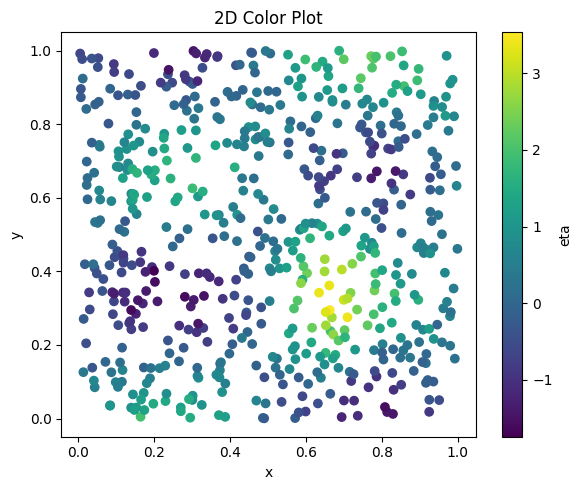

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df["x"], df["y"], c=df["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

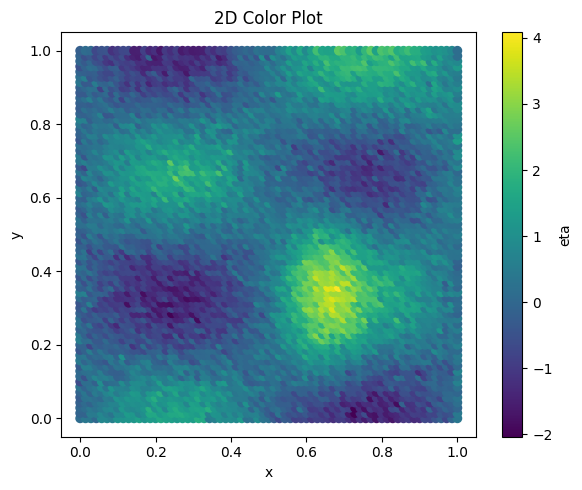

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

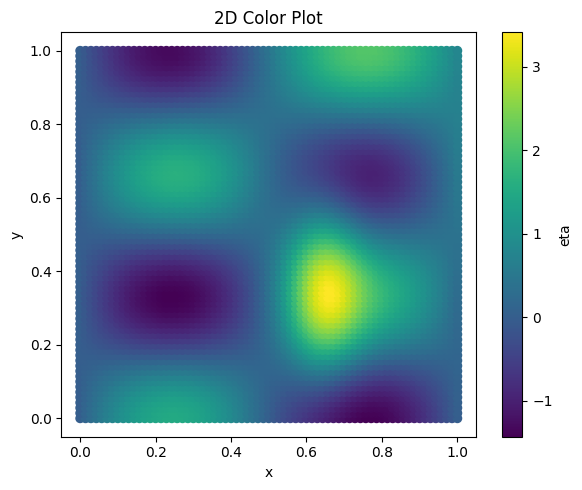

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["eta"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

## Model Definition

### Setup response model

In [24]:
tb = gam.TermBuilder.from_df(df)

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


z = lsl.Var.new_obs(
    value=df.z.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="z",
)

In [25]:
loc += (
    tb.ti("x", "y", bs="ps", k=10),
    tb.ps("x", k=20),
    tb.ps("y", k=20),
)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="z_value").value


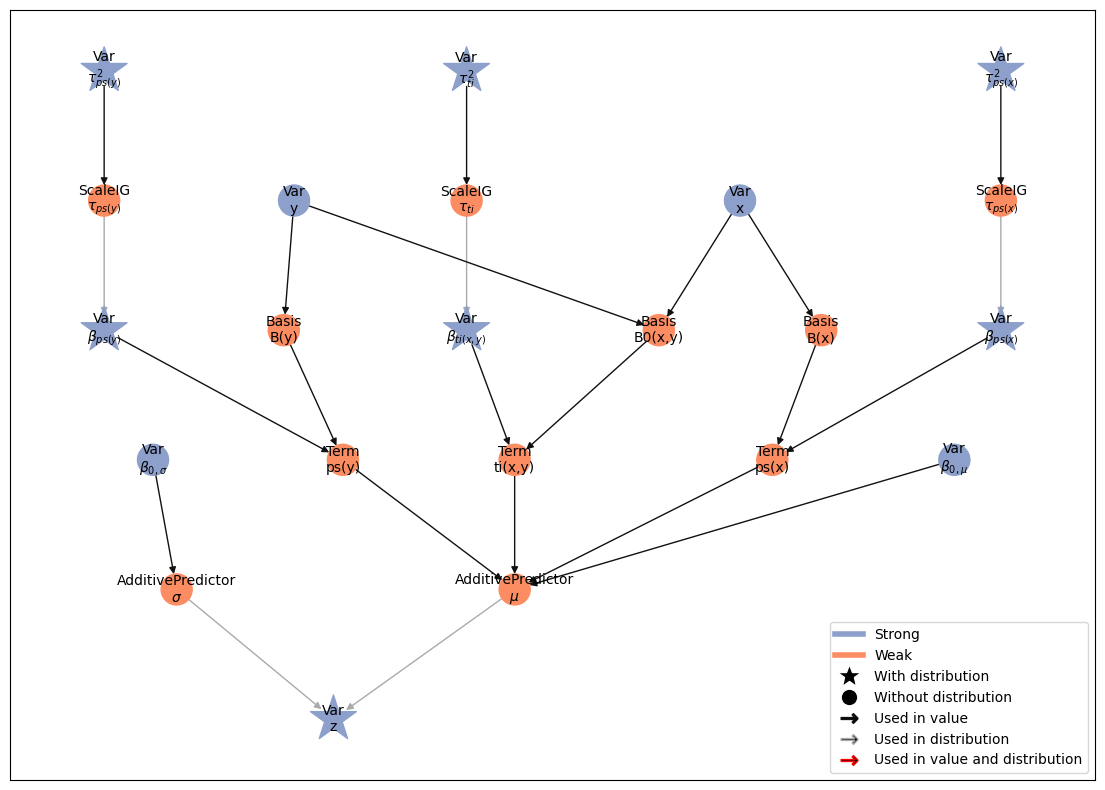

In [26]:
model = lsl.Model([z])
model.plot_vars()

## Run MCMC

In [27]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=1000,
        init_duration=200,
        term_duration=200,
        thinning_posterior=5,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{0,\\mu}$', '$\\beta_{ps(y)}$', '$\\tau^2_{ps(y)}$', '$\\beta_{ps(x)}$', '$\\tau^2_{ps(x)}$', '$\\beta_{ti(x,y)}$', '$\\tau^2_{ti}$'. The initial values for these keys won't be jittered


liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 200 transitions, 25 jitted together
100%|██████████████████████████████████████████| 8/8 [00:05<00:00,  1.42chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 719.06chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|█████████████████████████████████████████| 2/2 [00:00<00:00, 918.70chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 100 transitions, 25 jitted together
100%|████████████████████████████████████████| 4/4 [00:00<00:00, 1110.19chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - I

### MCMC summary

In [28]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel      mean        sd    q_0.05     q_0.5  \
parameter          index                                                      
$\beta_{0,\mu}$    ()     kernel_01  0.338626  0.011658  0.319507  0.338624   
$\beta_{0,\sigma}$ ()     kernel_00 -1.348033  0.031811 -1.399364 -1.347658   
$\beta_{ps(x)}$    (0,)   kernel_04  0.008475  0.062871 -0.092727  0.010212   
                   (1,)   kernel_04 -0.022726  0.065559 -0.126942 -0.020857   
                   (2,)   kernel_04 -0.004273  0.065832 -0.107275 -0.006644   
...                             ...       ...       ...       ...       ...   
$\beta_{ti(x,y)}$  (79,)  kernel_06  0.667318  0.233849  0.270887  0.676541   
                   (80,)  kernel_06  1.555339  0.643586  0.525545  1.518469   
$\tau^2_{ps(x)}$   ()     kernel_05  0.004967  0.002530  0.002237  0.004390   
$\tau^2_{ps(y)}$   ()     kernel_03  0.002158  0.001466  0.000815  0.001755   
$\tau^2_{ti}$      ()     kernel_07  0.106826  0.018869  0.078697  0.105705   

                            q_0.95  sample_size    ess_bulk    ess_tail  \
parameter          index                                                  
$\beta_{0,\mu}$    ()     0.358683          800  616.401240  731.960367   
$\beta_{0,\sigma}$ ()    -1.297209          800  492.625657  767.533013   
$\beta_{ps(x)}$    (0,)   0.106212          800  340.667304  550.885273   
                   (1,)   0.083763          800  394.757900  482.314914   
                   (2,)   0.101953          800  453.145154  676.918620   
...                            ...          ...         ...         ...   
$\beta_{ti(x,y)}$  (79,)  1.032737          800   41.359115  214.802270   
                   (80,)  2.721134          800   16.168798   74.195289   
$\tau^2_{ps(x)}$   ()     0.009860          800  326.310029  512.977778   
$\tau^2_{ps(y)}$   ()     0.004683          800  324.122127  390.428507   
$\tau^2_{ti}$      ()     0.140335          800  357.490619  535.658019   

                              rhat  
parameter          index            
$\beta_{0,\mu}$    ()     1.001022  
$\beta_{0,\sigma}$ ()     1.007560  
$\beta_{ps(x)}$    (0,)   1.017061  
                   (1,)   1.007939  
                   (2,)   1.009149  
...                            ...  
$\beta_{ti(x,y)}$  (79,)  1.077843  
                   (80,)  1.192225  
$\tau^2_{ps(x)}$   ()     1.005169  
$\tau^2_{ps(y)}$   ()     1.015233  
$\tau^2_{ti}$      ()     1.007001  

[124 rows x 10 columns]

## Predictions

In [29]:
samples = results.get_posterior_samples()

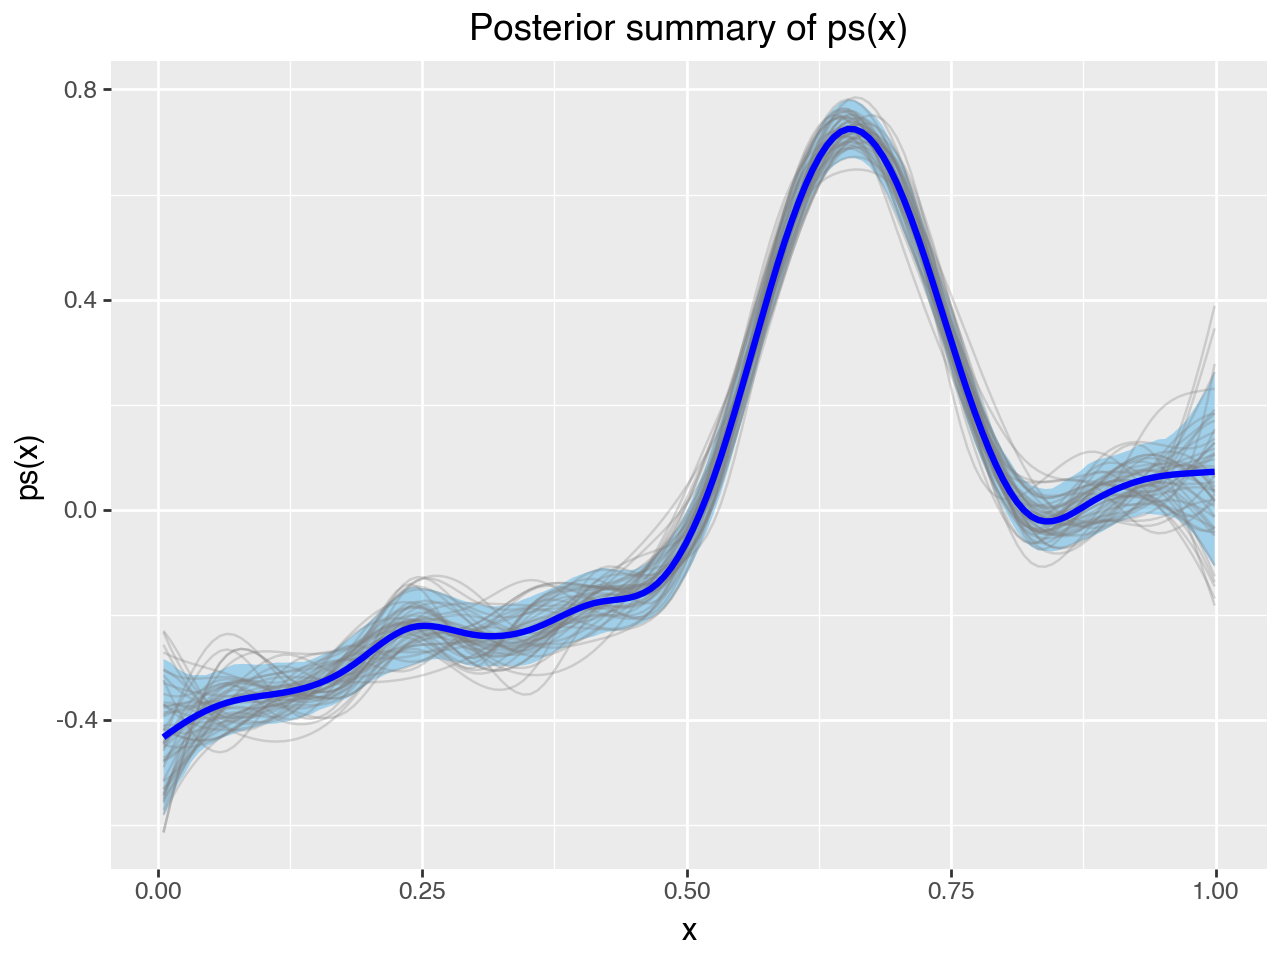

In [30]:
gam.plot_1d_smooth(term=model.vars["ps(x)"], samples=samples)

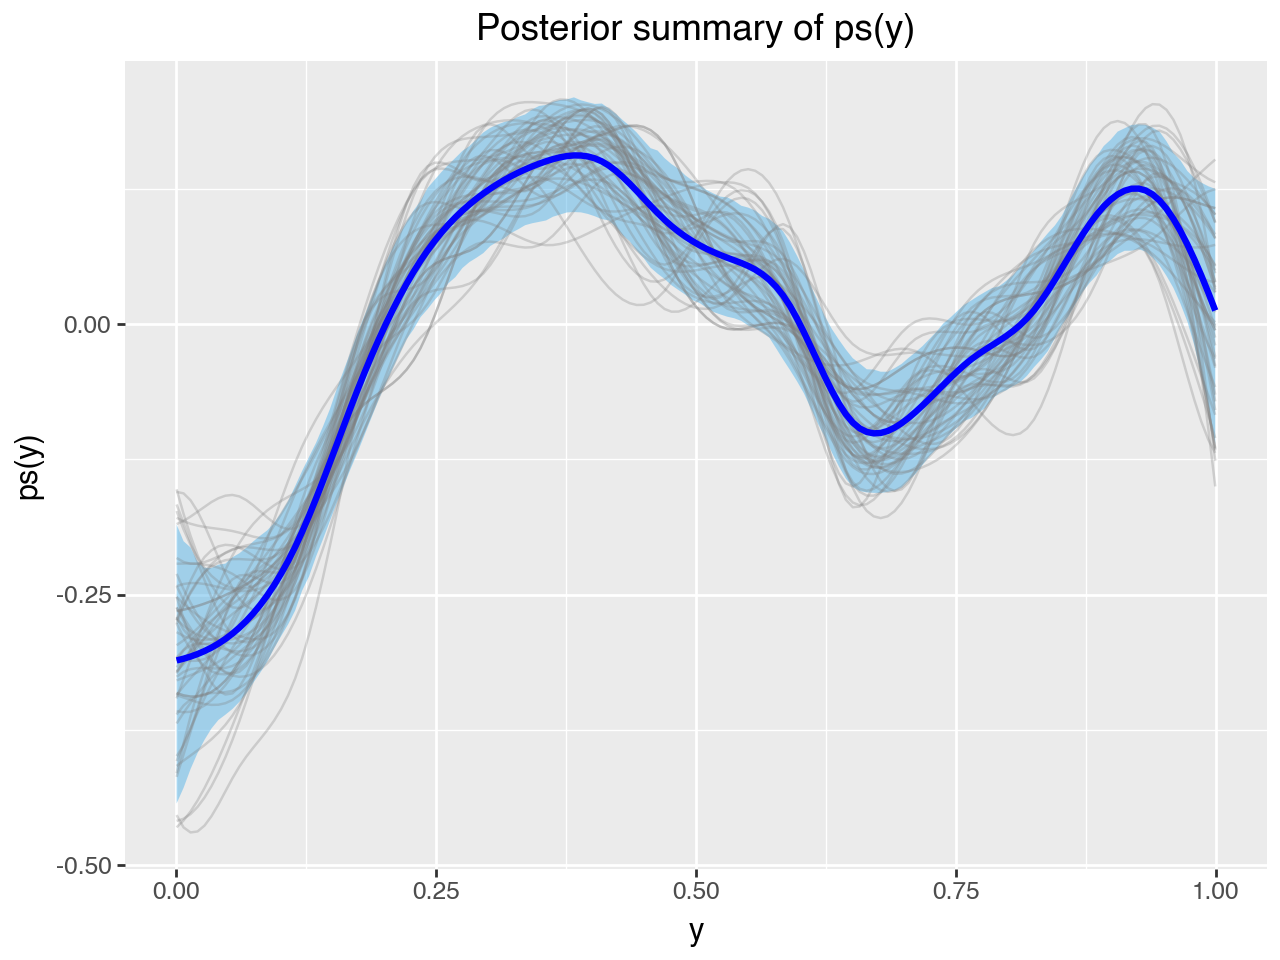

In [31]:
gam.plot_1d_smooth(term=model.vars["ps(y)"], samples=samples)

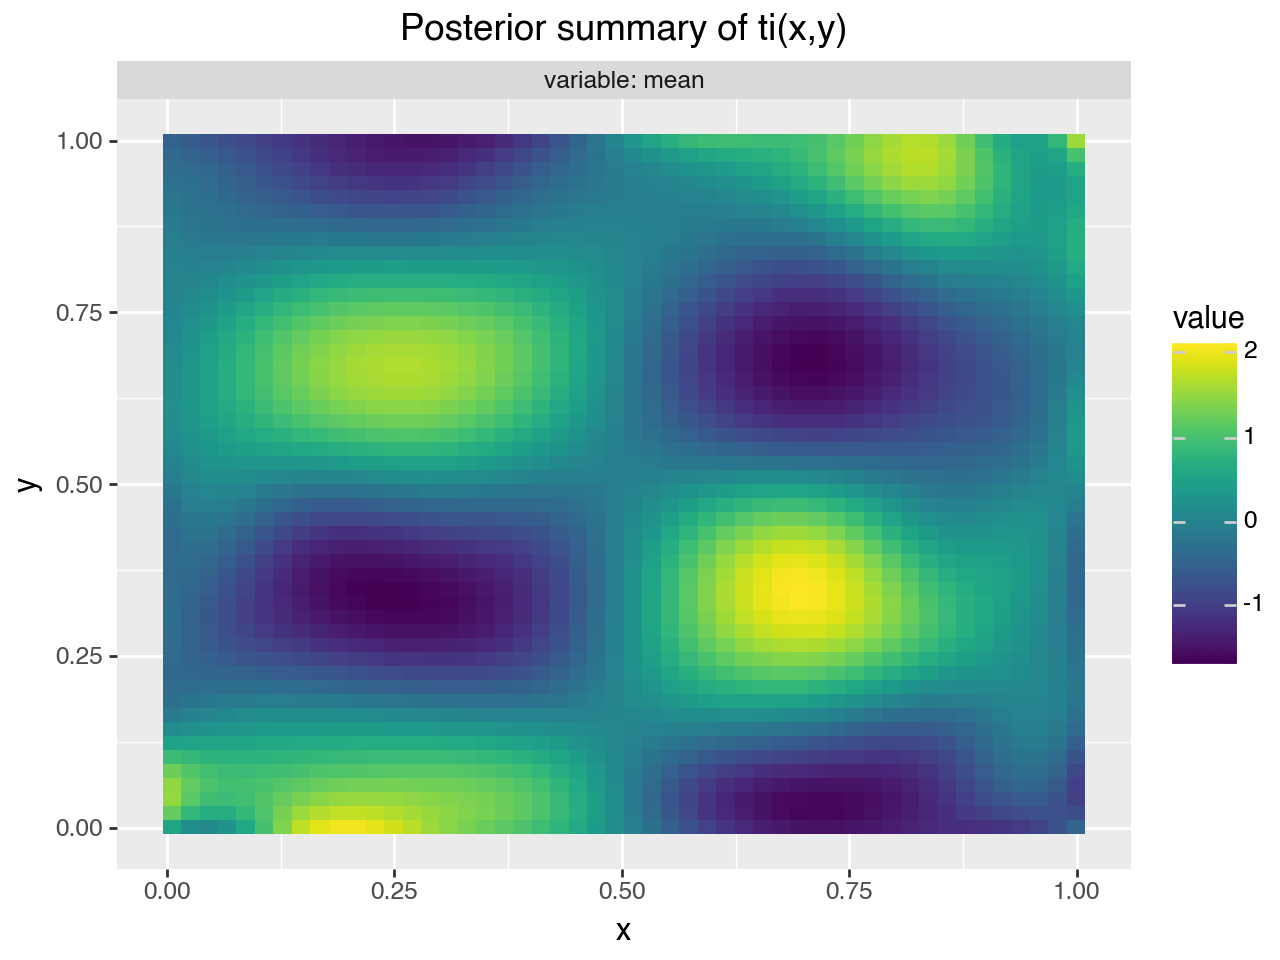

In [32]:
gam.plot_2d_smooth(
    term=loc.terms["ti(x,y)"],
    samples=samples,
    ngrid=50,
    which=["mean"],
)

### Predict variables at new x values

In [33]:
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["$\\mu$"],
    newdata={"x": df_grid.x.to_numpy(), "y": df_grid.y.to_numpy()},
)

In [34]:
predictions_summary = gs.SamplesSummary(predictions).to_dataframe().reset_index()
predictions_summary["x"] = np.tile(df_grid.x.to_numpy(), len(predictions))
predictions_summary["y"] = np.tile(df_grid.y.to_numpy(), len(predictions))
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,ess_bulk,ess_tail,mcse_mean,mcse_sd,rhat,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,x,y
0,$\mu$,$\mu$[0],"(0,)",800,0.232468,0.259142,0.509060,67.600801,101.471087,0.063016,0.031245,1.058885,-0.550963,0.193583,1.122979,-0.549399,1.124192,0.000000,0.0
1,$\mu$,$\mu$[1],"(1,)",800,-0.097113,0.270359,0.519961,61.511500,96.660717,0.067192,0.032030,1.055745,-0.919666,-0.116320,0.790461,-0.978377,0.698659,0.014286,0.0
2,$\mu$,$\mu$[2],"(2,)",800,-0.265806,0.389973,0.624478,74.591282,198.323958,0.072844,0.028505,1.044041,-1.219614,-0.292904,0.820037,-1.344021,0.669399,0.028571,0.0
3,$\mu$,$\mu$[3],"(3,)",800,-0.291076,0.484141,0.695803,85.583428,235.568085,0.075573,0.031246,1.038651,-1.374756,-0.326897,0.904182,-1.426633,0.824667,0.042857,0.0
4,$\mu$,$\mu$[4],"(4,)",800,-0.199638,0.501108,0.707889,92.720931,240.802555,0.073841,0.032854,1.034791,-1.293895,-0.227048,1.017313,-1.297437,1.002716,0.057143,0.0


### Plot fitted mean

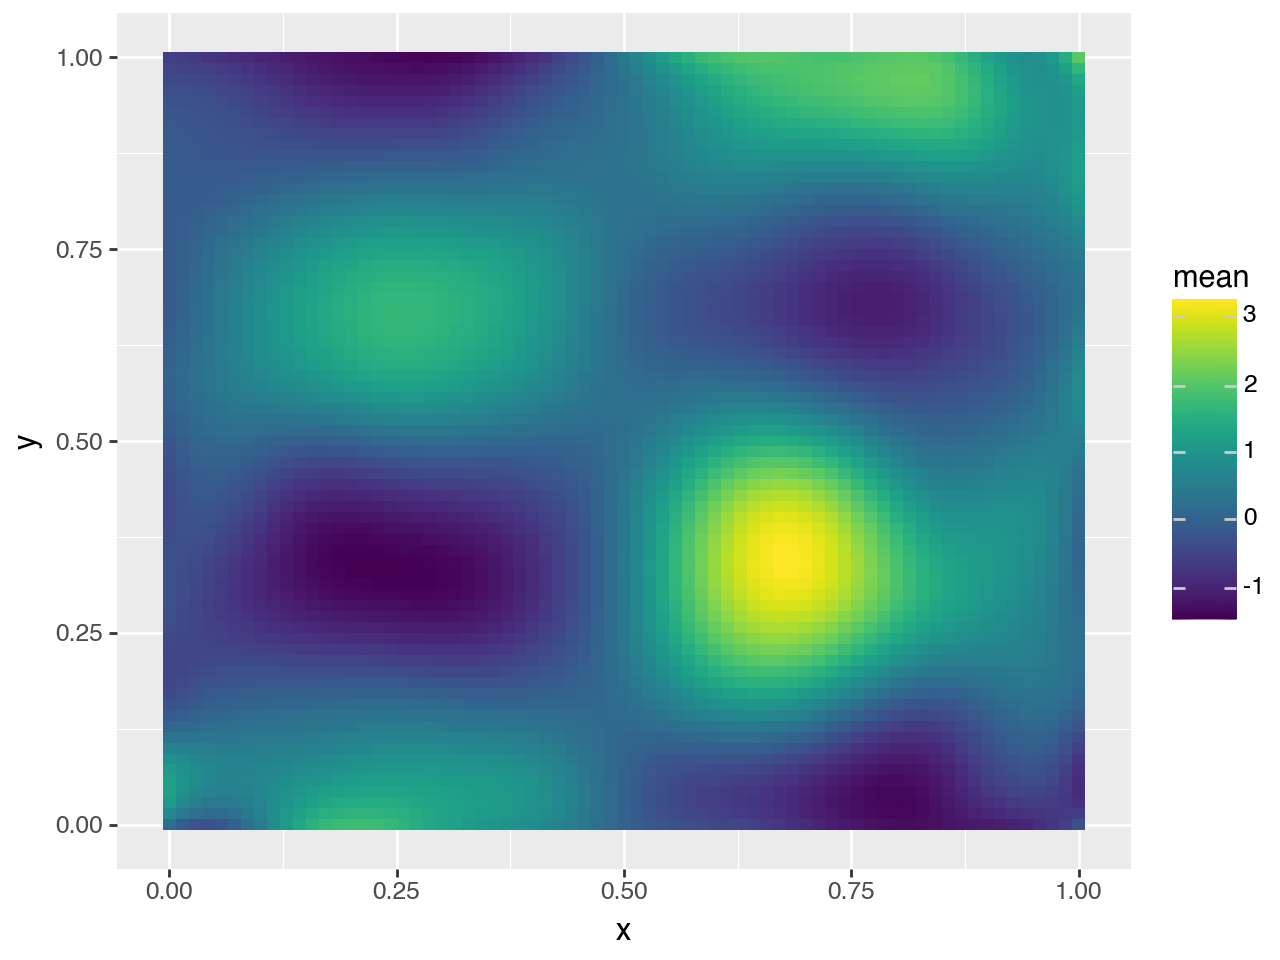

In [35]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))